In [1]:
import pandas as pd
import re
import io
import sys

## Open file paths storing the responses

In [2]:
# Dictionary containing file paths for each model and language pair
file_paths = {
    "gemini": {
        "en-es": "../gemini/results_gemini_en_es.csv",
        "es-en": "../gemini/results_gemini_es_en.csv",
        "es-ba": "../gemini/results_gemini_es_ba.csv",
        "en-ba": "../gemini/results_gemini_en_ba.csv",
        "ba-es": "../gemini/results_gemini_ba_es.csv",
        "ba-en": "../gemini/results_gemini_ba_en.csv",
    },
    "llama": {
        "en-es": "../llama/results_llama_en_es.csv",
        "es-en": "../llama/results_llama_es_en.csv",
        "es-ba": "../llama/results_llama_es_ba.csv",
        "en-ba": "../llama/results_llama_en_ba.csv",
        "ba-es": "../llama/results_llama_ba_es.csv",
        "ba-en": "../llama/results_llama_ba_en.csv",
    },
    "gpt": {
        "en-es": "../gpt/results_gpt_en_es.csv",
        "es-en": "../gpt/results_gpt_es_en.csv",
        "es-ba": "../gpt/results_gpt_es_ba.csv",
        "en-ba": "../gpt/results_gpt_en_ba.csv",
        "ba-es": "../gpt/results_gpt_ba_es.csv",
        "ba-en": "../gpt/results_gpt_ba_en.csv",
    },
    "latxa": {
        "es-ba": "../latxa/results_latxa_es_ba.csv",
        "en-ba": "../latxa/results_latxa_en_ba.csv",
        "ba-es": "../latxa/results_latxa_ba_es.csv",
        "ba-en": "../latxa/results_latxa_ba_en.csv",
    }
}

# Dictionary to store loaded DataFrames
dataframes = {}

# Iterate through each model and its language pairs
for model, language_pairs in file_paths.items():
    dataframes[model] = {}
    for language_pair, path in language_pairs.items():
        try:
            if isinstance(path, list):  # If multiple files are provided for a language pair
                # Load and concatenate all files into a single DataFrame
                dfs = [pd.read_csv(file) for file in path]
                concatenated_df = pd.concat(dfs, ignore_index=True)
                dataframes[model][language_pair] = concatenated_df
            else:  # Single file for the language pair
                df = pd.read_csv(path)
                dataframes[model][language_pair] = df
            print(f"✅ Loaded: {model} - {language_pair} | Shape: {dataframes[model][language_pair].shape}")
        except Exception as e:
            print(f"❌ Error loading {model} - {language_pair}: {e}")

✅ Loaded: gemini - en-es | Shape: (114, 6)
✅ Loaded: gemini - es-en | Shape: (71, 6)
✅ Loaded: gemini - es-ba | Shape: (199, 6)
✅ Loaded: gemini - en-ba | Shape: (170, 6)
✅ Loaded: gemini - ba-es | Shape: (44, 6)
✅ Loaded: gemini - ba-en | Shape: (44, 6)
✅ Loaded: llama - en-es | Shape: (114, 6)
✅ Loaded: llama - es-en | Shape: (71, 6)
✅ Loaded: llama - es-ba | Shape: (199, 6)
✅ Loaded: llama - en-ba | Shape: (170, 6)
✅ Loaded: llama - ba-es | Shape: (44, 6)
✅ Loaded: llama - ba-en | Shape: (44, 6)
✅ Loaded: gpt - en-es | Shape: (114, 6)
✅ Loaded: gpt - es-en | Shape: (71, 6)
✅ Loaded: gpt - es-ba | Shape: (199, 6)
✅ Loaded: gpt - en-ba | Shape: (170, 6)
✅ Loaded: gpt - ba-es | Shape: (44, 6)
✅ Loaded: gpt - ba-en | Shape: (44, 6)
✅ Loaded: latxa - es-ba | Shape: (100, 6)
✅ Loaded: latxa - en-ba | Shape: (80, 6)
✅ Loaded: latxa - ba-es | Shape: (44, 6)
✅ Loaded: latxa - ba-en | Shape: (44, 6)


In [3]:
print("📋 Columns per DataFrame:\n")
print(dataframes)

# Iterate through the models and their respective language pairs
for model_name, language_pairs in dataframes.items():
    for language_pair, dataframe in language_pairs.items():
        # Extract the column names from the DataFrame
        column_names = list(dataframe.columns)
        # Print the model, language pair, and column names
        print(f"🔹 Model: {model_name} | Language Pair: {language_pair} | Columns: {column_names}")

📋 Columns per DataFrame:

{'gemini': {'en-es':          term                                   pair_translation  \
0        cell  ('pila; pila electroquímica; pila galvánica', ...   
1        cell  ('pila; pila electroquímica; pila galvánica', ...   
2        cell  ('pila; pila electroquímica; pila galvánica', ...   
3        cell  ('pila; pila electroquímica; pila galvánica', ...   
4        cell  ('pila; pila electroquímica; pila galvánica', ...   
..        ...                                                ...   
109  transmit                      ('transmitir', 'transportar')   
110  transmit                      ('transmitir', 'transportar')   
111  transmit                      ('transmitir', 'transportar')   
112  transmit                      ('transmitir', 'transportar')   
113  transmit                      ('transmitir', 'transportar')   

                                        response_0shot  \
0    1. ...d el flujo de electricidad por otros med...   
1    1. ...y corrien

In [4]:
# Generate word variants based on the target language
def generate_variants_es(word):
    """
    Generate Spanish variants for a given word.

    Args:
        word (str): The input word.

    Returns:
        list: A list of possible variants for the word in Spanish.
    """
    word = word.lower()
    variants = [word]
    if word.endswith(('a', 'e', 'i', 'o', 'u')):
        variants.append(word + 's')
    else:
        variants.append(word + 'es')
    return variants

def generate_variants_en(word):
    """
    Generate English variants for a given word.

    Args:
        word (str): The input word.

    Returns:
        list: A list of possible variants for the word in English.
    """
    word = word.lower()
    variants = [word]
    if word.endswith(('s', 'x', 'z', 'ch', 'sh')):
        variants.append(word + 'es')
    elif word.endswith('y') and word[-2] not in 'aeiou':
        variants.append(word[:-1] + 'ies')
    else:
        variants.append(word + 's')
    if not word.endswith('e'):
        variants.append(word + 'ing')
        variants.append(word + 'ed')
    else:
        variants.append(word[:-1] + 'ing')
        variants.append(word + 'd')
    return variants

def generate_variants_ba(word):
    """
    Generate Basque variants for a given word.

    Args:
        word (str): The input word.

    Returns:
        list: A list containing the exact lowercase variant of the word.
    """
    return [word.lower()]

In [5]:
import re
import ast

# ============================================
# 📄 Evaluation of Terminological Translations in Generative Models
# ============================================
# This script evaluates responses generated by language models (e.g., GPT)
# that translate contexts containing marked terms with **.
#
# ✔️ What is evaluated?
# It checks whether the model correctly translates the expected term
# by comparing the response with possible variants of the translated term.
#
# ✔️ How does it work?
# - Each response is divided into two blocks (e.g., translation of term 1 and term 2)
# - It validates whether the term appears correctly in its corresponding block
# - If the model marked the term with **, that is prioritized
# - If not marked, it looks for an exact match within the block
# - It is only accepted if it appears ONCE and in a "central" position of the block
#
# ✔️ Result:
# Accuracy is calculated (correct / total) for different prompt types (0-shot, few-shot, etc.)
#
# ⚠️ Requirements:
# - The column 'pair_translation' must contain the expected terms (in the format 'original, translated')
# - The columns 'response_*' must contain the responses generated by the models
# ============================================


def validate_block(block, expected_options, generate_variants, target_language):
    """
    Validates whether a block contains the expected term.
    Prioritizes words marked with **, and allows a valid match 
    either within a reasonable position in the text or anywhere 
    if only one occurrence is found.
    """
    match = re.search(r'\*\*(.*?)\*\*', block)
    valid_variants = []
    for option in expected_options:
        valid_variants.extend(generate_variants(option))

    if match:
        extracted_word = match.group(1).strip().lower()
        if target_language == 'ba':
            return any(variant in extracted_word for variant in valid_variants)
        else:
            return extracted_word in valid_variants
    else:
        block_lower = block.lower()
        block_length = len(block_lower)

        valid_occurrences = []
        for variant in valid_variants:
            if target_language == 'ba':
                for m in re.finditer(re.escape(variant), block_lower):
                    valid_occurrences.append(m.start())
            else:
                for m in re.finditer(rf'\b{re.escape(variant)}\b', block_lower):
                    valid_occurrences.append(m.start())

        if len(valid_occurrences) == 1:
            position = valid_occurrences[0]
            if 0.3 * block_length <= position <= 0.7 * block_length:
                return True
        return False

def evaluate_dataframe(dataframe, language_pair):
    """
    Main function to evaluate the dataframe containing model responses.
    Calculates accuracy for different prompt types (0-shot, few-shot, etc.).
    """
    source_language, target_language = language_pair.split('-')

    if target_language == 'es':
        generate_variants = generate_variants_es
    elif target_language == 'en':
        generate_variants = generate_variants_en
    elif target_language == 'ba':
        generate_variants = generate_variants_ba
    else:
        raise ValueError(f"Unrecognized target language: {target_language}")

    response_types = ['response_0shot', 'response_0shotplus', 'response_1shot', 'response_fewshot']
    results = {response_type: {'correct': 0, 'incorrect': 0} for response_type in response_types}

    for _, row in dataframe.iterrows():
        # Skip empty rows or rows with missing data messages
        if any("prompt not constructed" in str(row.get(response_type, "")).lower() for response_type in response_types):
            continue

        try:
            raw_pair = row['pair_translation'].strip("()")
            parts = [p.strip().strip("'") for p in raw_pair.split(',')]
            options_1 = [o.strip().lower() for o in parts[0].split(';')]
            options_2 = [o.strip().lower() for o in parts[1].split(';')]
            expected_terms = [options_1, options_2]
        except:
            continue  # Skip if there is a format error in the pair

        for response_type in response_types:
            response = str(row.get(response_type, "")).strip()
            if not response:
                continue

            # 🌍 SPECIAL CASE: source language = BA (GARATERM corpus)
            if source_language == 'ba':
                response = response.lower()
                blocks = re.split(r'\n+2[\.\s:]*', response)
                correct_count = 0

                for i in range(min(len(blocks), len(expected_terms))):
                    block = blocks[i]
                    valid_variants = []
                    for option in expected_terms[i]:
                        valid_variants.extend(generate_variants(option))

                    # 🔎 Extract only lines resembling direct translations
                    translation_lines = []
                    for line in block.split('\n'):
                        line_lower = line.lower().strip()
                        if any(x in line_lower for x in ["note", "explanation", "example"]):
                            continue
                        if (
                            "translation" in line_lower or
                            "->" in line_lower or
                            re.match(r"^\s*\d[\.\)]", line_lower) or
                            len(line_lower.split()) > 3
                        ):
                            translation_lines.append(line.strip())

                    text_to_validate = " ".join(translation_lines).lower()
                    found = False

                    if target_language == 'ba':
                        found = any(variant in text_to_validate for variant in valid_variants)
                    else:
                        for variant in valid_variants:
                            if re.search(rf'\b{re.escape(variant)}\b', text_to_validate):
                                found = True
                                break

                    if found:
                        correct_count += 1

                incorrect_count = len(expected_terms) - correct_count
                results[response_type]['correct'] += correct_count
                results[response_type]['incorrect'] += incorrect_count

            # 🧪 GENERAL CASE: normal evaluation
            else:
                response = response.lower()
                blocks = re.split(r'\n+2\.\s*\.\.\.', response)
                correct_count = 0

                for i in range(min(len(blocks), len(expected_terms))):
                    block = blocks[i]
                    if validate_block(block, expected_terms[i], generate_variants, target_language):
                        correct_count += 1

                incorrect_count = len(expected_terms) - correct_count
                results[response_type]['correct'] += correct_count
                results[response_type]['incorrect'] += incorrect_count

    # Display final results
    for response_type, result in results.items():
        total = result['correct'] + result['incorrect']
        accuracy = (result['correct'] / total * 100) if total > 0 else 0
        print(f"📊 {response_type}: {result} → Accuracy: {accuracy:.2f}%")
        
    return results


In [6]:
## Evaluation of all models

# Iterate through all models and their language pairs
for model_name, language_pairs in dataframes.items():
    for language_pair, dataframe in language_pairs.items():
        # Only evaluate language pairs where the source language is Basque (ba)
        if language_pair.startswith("ba-"):
            print("\n==============================")
            print(f"🔍 Evaluating Model: {model_name.upper()} | Translation Pair: {language_pair}")
            print("==============================")
            evaluate_dataframe(dataframe, language_pair)


🔍 Evaluating Model: GEMINI | Translation Pair: ba-es
📊 response_0shot: {'correct': 40, 'incorrect': 48} → Accuracy: 45.45%
📊 response_0shotplus: {'correct': 73, 'incorrect': 15} → Accuracy: 82.95%
📊 response_1shot: {'correct': 64, 'incorrect': 24} → Accuracy: 72.73%
📊 response_fewshot: {'correct': 64, 'incorrect': 24} → Accuracy: 72.73%

🔍 Evaluating Model: GEMINI | Translation Pair: ba-en
📊 response_0shot: {'correct': 37, 'incorrect': 51} → Accuracy: 42.05%
📊 response_0shotplus: {'correct': 65, 'incorrect': 23} → Accuracy: 73.86%
📊 response_1shot: {'correct': 57, 'incorrect': 31} → Accuracy: 64.77%
📊 response_fewshot: {'correct': 41, 'incorrect': 47} → Accuracy: 46.59%

🔍 Evaluating Model: LLAMA | Translation Pair: ba-es
📊 response_0shot: {'correct': 33, 'incorrect': 55} → Accuracy: 37.50%
📊 response_0shotplus: {'correct': 80, 'incorrect': 8} → Accuracy: 90.91%
📊 response_1shot: {'correct': 77, 'incorrect': 11} → Accuracy: 87.50%
📊 response_fewshot: {'correct': 66, 'incorrect': 22} →

"Given that the GARATERM corpus presents noisier responses and lacks a clear structure, additional defensive validation was applied, requiring the term to appear only once in the lines of the block with indications of translation. This reduces false positives derived from metalinguistic mentions, repetitions, or model ambiguity."

In [7]:
import io
import sys

# Open a file to save the evaluation results
with open("total_results_accuracy.txt", "w", encoding="utf-8") as output_file:
    # Iterate through each model and its language pairs
    for model_name, language_pairs in dataframes.items():
        for language_pair, dataframe in language_pairs.items():
            # Header for the current evaluation
            header = (
                f"\n==============================\n"
                f"🔍 Evaluating Model: {model_name.upper()} | Translation Pair: {language_pair}\n"
                f"=============================="
            )
            print(header)
            output_file.write(header + "\n")

            # Capture the output of the evaluation function
            output_buffer = io.StringIO()
            original_stdout = sys.stdout
            sys.stdout = output_buffer  # Redirect stdout to the buffer

            # Evaluate the dataframe for the current language pair
            evaluate_dataframe(dataframe, language_pair)

            # Restore the original stdout
            sys.stdout = original_stdout
            evaluation_result = output_buffer.getvalue()

            # Print and save the evaluation result
            print(evaluation_result)
            output_file.write(evaluation_result + "\n")


🔍 Evaluating Model: GEMINI | Translation Pair: en-es
📊 response_0shot: {'correct': 75, 'incorrect': 153} → Accuracy: 32.89%
📊 response_0shotplus: {'correct': 147, 'incorrect': 81} → Accuracy: 64.47%
📊 response_1shot: {'correct': 141, 'incorrect': 87} → Accuracy: 61.84%
📊 response_fewshot: {'correct': 122, 'incorrect': 106} → Accuracy: 53.51%


🔍 Evaluating Model: GEMINI | Translation Pair: es-en
📊 response_0shot: {'correct': 61, 'incorrect': 81} → Accuracy: 42.96%
📊 response_0shotplus: {'correct': 86, 'incorrect': 56} → Accuracy: 60.56%
📊 response_1shot: {'correct': 88, 'incorrect': 54} → Accuracy: 61.97%
📊 response_fewshot: {'correct': 77, 'incorrect': 65} → Accuracy: 54.23%


🔍 Evaluating Model: GEMINI | Translation Pair: es-ba
📊 response_0shot: {'correct': 145, 'incorrect': 253} → Accuracy: 36.43%
📊 response_0shotplus: {'correct': 298, 'incorrect': 100} → Accuracy: 74.87%
📊 response_1shot: {'correct': 268, 'incorrect': 130} → Accuracy: 67.34%
📊 response_fewshot: {'correct': 206, 'i

Tests from here to try another type of evaluation.

In [8]:
def get_evaluation_results_with_confusion(dataframe, language_pair):
    """
    Evaluates a DataFrame containing model responses for terminological translations,
    calculating global results (accuracy, confusion, error) and results per term.

    Args:
        dataframe (pd.DataFrame): The DataFrame containing model responses.
                                   It must include columns like 'pair_translation', 'term', and response types.
        language_pair (str): The language pair in the format 'source-target' (e.g., 'en-es').

    Returns:
        tuple: A tuple containing:
            - global_results (dict): A dictionary with global counts of 'correct', 'confusion', and 'error'
                                     for each response type.
            - term_results (dict): A dictionary with counts of 'correct', 'confusion', and 'error'
                                   for each term and response type.
    """
    source_lang, target_lang = language_pair.split('-')

    # Map target language to the appropriate variant generation function
    if target_lang == 'es':
        generate_variants = generate_variants_es
    elif target_lang == 'en':
        generate_variants = generate_variants_en
    elif target_lang == 'ba':
        generate_variants = generate_variants_ba
    else:
        raise ValueError(f"Unrecognized target language: {target_lang}")

    response_types = ['response_0shot', 'response_0shotplus', 'response_1shot', 'response_fewshot']

    # Initialize results dictionaries
    global_results = {response: {'correct': 0, 'confusion': 0, 'error': 0} for response in response_types}
    term_results = {}

    for index, row in dataframe.iterrows():
        # Parse the pair_translation column
        raw_pair = str(row.get('pair_translation', '')).strip("()")
        parts = [p.strip().strip("'") for p in raw_pair.split(',')]

        if len(parts) != 2:
            continue

        expected_options_1 = [option.strip() for option in parts[0].split(';')]
        expected_options_2 = [option.strip() for option in parts[1].split(';')]
        expected_terms_list = [expected_options_1, expected_options_2]

        # Normalize the term
        term = str(row.get('term', f'unknown_term_{index}')).strip().lower()
        if term not in term_results:
            term_results[term] = {
                response: {'correct': 0, 'confusion': 0, 'error': 0} for response in response_types
            }

        for response_type in response_types:
            response = row.get(response_type, None)

            # Handle missing or invalid responses
            if pd.isna(response) or not isinstance(response, str):
                response_str = ""
            else:
                response_str = response.strip()

            if source_lang == 'ba':
                blocks = re.split(r'\n+2[\.\s:]*', response_str.lower())

                for i in range(2):
                    if i >= len(expected_terms_list):
                        global_results[response_type]['error'] += 1
                        term_results[term][response_type]['error'] += 1
                        continue

                    # Generate expected variants for the current and other terms
                    expected_variants_current = [
                        variant for option in expected_terms_list[i]
                        for variant in generate_variants(str(option).strip()) if option
                    ]
                    other_index = 1 - i
                    expected_variants_other = [
                        variant for option in expected_terms_list[other_index]
                        for variant in generate_variants(str(option).strip()) if option
                    ]

                    if i < len(blocks):
                        block = blocks[i].strip()

                        # Extract translation lines
                        translation_lines = [
                            line.lower().strip() for line in block.split('\n')
                            if not any(keyword in line.lower() for keyword in ["note", "explanation", "example"])
                            and (
                                "translation" in line.lower() or
                                "->" in line.lower() or
                                re.match(r"^\s*\d[\.\)]", line.lower()) or
                                len(line.split()) > 3
                            )
                        ]
                        text_to_validate = " ".join(translation_lines)

                        # Determine result
                        found_correct = any(
                            variant in text_to_validate for variant in expected_variants_current
                        )
                        found_confusion = not found_correct and any(
                            variant in text_to_validate for variant in expected_variants_other
                        )

                        if found_correct:
                            result = "correct"
                        elif found_confusion:
                            result = "confusion"
                        else:
                            result = "error"
                    else:
                        result = "error"

                    global_results[response_type][result] += 1
                    term_results[term][response_type][result] += 1

            else:
                blocks = re.split(r'\n+2\.\s*\.\.\.', response_str)

                for i in range(2):
                    if i >= len(expected_terms_list):
                        global_results[response_type]['error'] += 1
                        term_results[term][response_type]['error'] += 1
                        continue

                    if i < len(blocks):
                        block = blocks[i]
                        if validate_block(block, expected_terms_list[i], generate_variants, target_lang):
                            result = "correct"
                        elif validate_block(block, expected_terms_list[1 - i], generate_variants, target_lang):
                            result = "confusion"
                        else:
                            result = "error"
                    else:
                        result = "error"

                    global_results[response_type][result] += 1
                    term_results[term][response_type][result] += 1

    return global_results, term_results


In [9]:
def display_evaluation_results_with_confusion(global_results, title="Evaluation Results Summary"):
    """
    Displays the summary of evaluation results (accuracy, confusion, error)
    for different prompt types based on global counts.

    Args:
        global_results (dict): A dictionary with prompt types as keys,
                               and values as dicts with 'correct', 'confusion', 'error' counts
                               (e.g., as returned by get_evaluation_results_with_confusion).
        title (str): A title for the summary.
    """
    print(f"\n========== {title.upper()} ==========")
    if not global_results or all(sum(counts.values()) == 0 for counts in global_results.values()):
        print("No data available for display.")
        print("====================================")
        return

    # Convert to DataFrame for nice printing
    summary_data = []
    for response_type, counts in global_results.items():
        total = sum(counts.values())
        if total == 0:
            summary_data.append({
                'Prompt Type': response_type,
                'Correct Count': 0,
                'Confusion Count': 0,
                'Error Count': 0,
                'Total': 0,
                'Accuracy (%)': 0.0,
                'Confusion (%)': 0.0,
                'Error (%)': 0.0
            })
            continue

        accuracy = (counts['correct'] / total) * 100
        confusion = (counts['confusion'] / total) * 100
        error = (counts['error'] / total) * 100

        summary_data.append({
            'Prompt Type': response_type,
            'Correct Count': counts['correct'],
            'Confusion Count': counts['confusion'],
            'Error Count': counts['error'],
            'Total': total,
            'Accuracy (%)': round(accuracy, 2),
            'Confusion (%)': round(confusion, 2),
            'Error (%)': round(error, 2)
        })

    df_summary = pd.DataFrame(summary_data)
    # Sort by Prompt Type for consistent display order
    df_summary['Prompt Type Order'] = df_summary['Prompt Type'].apply(
        lambda x: ['response_0shot', 'response_0shotplus', 'response_1shot', 'response_fewshot'].index(x) if x in ['response_0shot', 'response_0shotplus', 'response_1shot', 'response_fewshot'] else 99
    )
    df_summary = df_summary.sort_values(by='Prompt Type Order').drop('Prompt Type Order', axis=1)

    # Display the DataFrame
    print(df_summary.to_string(index=False))
    print("====================================")

In [10]:
# Evaluate the global results and results per term for the 'en-ba' language pair using the GPT model
global_results, term_res_gpt_en_ba = get_evaluation_results_with_confusion(dataframes['gpt']['en-ba'], 'en-ba')

print(display_evaluation_results_with_confusion(global_results, title="GPT Evaluation Results Summary for en-ba"))

# Display the results for the specific term 'fracture'
#term_res_gpt_en_ba['fracture']


========== GPT EVALUATION RESULTS SUMMARY FOR EN-BA ==========
       Prompt Type  Correct Count  Confusion Count  Error Count  Total  Accuracy (%)  Confusion (%)  Error (%)
    response_0shot            129              109          102    340         37.94          32.06      30.00
response_0shotplus            271                9           60    340         79.71           2.65      17.65
    response_1shot            230               21           89    340         67.65           6.18      26.18
  response_fewshot            221               33           86    340         65.00           9.71      25.29
None


We are going to evaluate the performance of each model and language pair, calculating the average accuracy of their terms.

In [11]:
def compare_all_model_performances(dataframes_dict):
    """
    Evaluate all models across all available language pairs and return
    a comprehensive DataFrame comparing their performance (Accuracy, Confusion, Error rates).

    Args:
        dataframes_dict (dict): Dictionary containing loaded DataFrames,
                                structured as {model_name: {language_pair: DataFrame}}.

    Returns:
        pd.DataFrame: A DataFrame showing Accuracy, Confusion, and Error rates
                      for each model, language pair, and prompt type.
    """
    results = []

    for model_name, language_pairs in dataframes_dict.items():
        for language_pair, dataframe in language_pairs.items():
            print(f"Evaluating {model_name.upper()} - {language_pair}...")

            if dataframe.empty:
                print(f"Skipping {model_name.upper()} - {language_pair}: DataFrame is empty.")
                continue

            # Get evaluation results for the current DataFrame
            global_results, _ = get_evaluation_results_with_confusion(dataframe, language_pair)

            for prompt_type, metrics in global_results.items():
                total_evaluations = sum(metrics.values())
                accuracy = (metrics['correct'] / total_evaluations * 100) if total_evaluations > 0 else 0.0
                confusion = (metrics['confusion'] / total_evaluations * 100) if total_evaluations > 0 else 0.0
                error = (metrics['error'] / total_evaluations * 100) if total_evaluations > 0 else 0.0

                results.append({
                    'Model': model_name,
                    'Language Pair': language_pair,
                    'Prompt Type': prompt_type,
                    'Correct Count': metrics['correct'],
                    'Confusion Count': metrics['confusion'],
                    'Error Count': metrics['error'],
                    'Total Evaluations': total_evaluations,
                    'Accuracy (%)': round(accuracy, 2),
                    'Confusion (%)': round(confusion, 2),
                    'Error (%)': round(error, 2)
                })

    if not results:
        return pd.DataFrame()  # Return an empty DataFrame if no results are available

    # Create a DataFrame from the results
    comparison_df = pd.DataFrame(results)

    # Reorder columns for better readability
    comparison_df = comparison_df[[
        'Model', 'Language Pair', 'Prompt Type', 'Total Evaluations',
        'Correct Count', 'Accuracy (%)', 'Confusion Count', 'Confusion (%)',
        'Error Count', 'Error (%)'
    ]]

    return comparison_df

In [12]:
import pandas as pd

# Configurar pandas para mostrar todas las filas y columnas
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

print("\n--- Comparative Performance of All Models Across All Language Pairs ---")

# Generar un DataFrame comparativo del rendimiento de todos los modelos
comparison_dataframe = compare_all_model_performances(dataframes)

# Mostrar solo las columnas relevantes para una comparación de alto nivel
columns_to_display = ['Model', 'Language Pair', 'Prompt Type', 'Accuracy (%)', 'Confusion (%)', 'Error (%)']
print(comparison_dataframe[columns_to_display])

# Restablecer las opciones de pandas a los valores predeterminados si es necesario
pd.reset_option('display.max_rows')
pd.reset_option('display.max_columns')


--- Comparative Performance of All Models Across All Language Pairs ---
Evaluating GEMINI - en-es...
Evaluating GEMINI - es-en...
Evaluating GEMINI - es-ba...
Evaluating GEMINI - en-ba...
Evaluating GEMINI - ba-es...
Evaluating GEMINI - ba-en...
Evaluating LLAMA - en-es...
Evaluating LLAMA - es-en...
Evaluating LLAMA - es-ba...
Evaluating LLAMA - en-ba...
Evaluating LLAMA - ba-es...
Evaluating LLAMA - ba-en...
Evaluating GPT - en-es...
Evaluating GPT - es-en...
Evaluating GPT - es-ba...
Evaluating GPT - en-ba...
Evaluating GPT - ba-es...
Evaluating GPT - ba-en...
Evaluating LATXA - es-ba...
Evaluating LATXA - en-ba...
Evaluating LATXA - ba-es...
Evaluating LATXA - ba-en...
     Model Language Pair         Prompt Type  Accuracy (%)  Confusion (%)  \
0   gemini         en-es      response_0shot         32.89          33.77   
1   gemini         en-es  response_0shotplus         64.47           7.02   
2   gemini         en-es      response_1shot         61.84           7.02   
3   gemin

Below we will filter the extracted terms with their accuracy by a minimum of confusion and error.

In [13]:
def get_challenging_terms(term_results_dict, min_error_rate=0.2, min_confusion_rate=0.2, prompt_type=None):
    """
    Identifies terms that are challenging for translation based on their error and/or confusion rates.

    Args:
        term_results_dict (dict): The dictionary of results per term (e.g., from evaluate_dataframe_with_confusion).
                                  Structured as {term: {prompt_type: {'correct': X, 'confusion': Y, 'error': Z}, ...}}.
        min_error_rate (float): Minimum error rate (as a proportion, e.g., 0.2 for 20%)
                                 for a term to be considered challenging due to errors.
        min_confusion_rate (float): Minimum confusion rate (as a proportion)
                                    for a term to be considered challenging due to confusion.
        prompt_type (str, optional): Specific prompt type to analyze (e.g., 'response_0shot').
                                     If None, aggregates results across all prompt types for each term.

    Returns:
        pd.DataFrame: A DataFrame listing challenging terms with their aggregated performance metrics,
                      sorted by error and then confusion rate in descending order.
    """
    challenging_terms_data = []

    for term, prompt_data in term_results_dict.items():
        aggregated_counts = {'correct': 0, 'confusion': 0, 'error': 0}
        total_evaluations = 0

        if prompt_type and prompt_type in prompt_data:
            counts = prompt_data[prompt_type]
            aggregated_counts['correct'] += counts.get('correct', 0)
            aggregated_counts['confusion'] += counts.get('confusion', 0)
            aggregated_counts['error'] += counts.get('error', 0)
            total_evaluations = sum(counts.values())
        elif not prompt_type: # Aggregate across all prompt types if no specific prompt_type is given
            for p_type, counts in prompt_data.items():
                aggregated_counts['correct'] += counts.get('correct', 0)
                aggregated_counts['confusion'] += counts.get('confusion', 0)
                aggregated_counts['error'] += counts.get('error', 0)
                total_evaluations += sum(counts.values())
        else: # prompt_type specified but not found for this term
            continue

        if total_evaluations == 0:
            continue

        error_rate = aggregated_counts['error'] / total_evaluations
        confusion_rate = aggregated_counts['confusion'] / total_evaluations
        accuracy_rate = aggregated_counts['correct'] / total_evaluations

        if error_rate >= min_error_rate or confusion_rate >= min_confusion_rate:
            challenging_terms_data.append({
                'Term': term,
                'Total Evaluations': total_evaluations,
                'Correct Count': aggregated_counts['correct'],
                'Accuracy (%)': round(accuracy_rate * 100, 2),
                'Confusion Count': aggregated_counts['confusion'],
                'Confusion (%)': round(confusion_rate * 100, 2),
                'Error Count': aggregated_counts['error'],
                'Error (%)': round(error_rate * 100, 2)
            })

    df_challenging_terms = pd.DataFrame(challenging_terms_data)
    if not df_challenging_terms.empty:
        df_challenging_terms = df_challenging_terms.sort_values(by=['Error (%)', 'Confusion (%)'], ascending=False).reset_index(drop=True)
    return df_challenging_terms

In [14]:
print("\n--- Challenging Terms for GPT (en-ba) with Error or Confusion Rate > 20% (Aggregated) ---")
# Retrieve challenging terms for GPT (en-ba) with aggregated error or confusion rate > 20%
challenging_terms_gpt_en_ba_df = get_challenging_terms(
    term_results_dict=term_res_gpt_en_ba, 
    min_error_rate=0.2, 
    min_confusion_rate=0.2, 
    prompt_type=None
)

# Display results if any challenging terms are found
if not challenging_terms_gpt_en_ba_df.empty:
    print(challenging_terms_gpt_en_ba_df)
else:
    print("No terms found to be challenging based on the specified criteria for GPT (en-ba).")

print("\n--- Challenging Terms for GPT (en-ba) - response_0shot (Error or Confusion Rate > 30%) ---")
# Retrieve challenging terms for GPT (en-ba) with response_0shot and error/confusion rate > 30%
challenging_terms_gpt_en_ba_0shot_df = get_challenging_terms(
    term_results_dict=term_res_gpt_en_ba, 
    min_error_rate=0.3, 
    min_confusion_rate=0.3, 
    prompt_type='response_0shot'
)

# Display results if any challenging terms are found for response_0shot
if not challenging_terms_gpt_en_ba_0shot_df.empty:
    print(challenging_terms_gpt_en_ba_0shot_df)
else:
    print("No terms found to be challenging based on the specified criteria for GPT (en-ba) - response_0shot.")


--- Challenging Terms for GPT (en-ba) with Error or Confusion Rate > 20% (Aggregated) ---
            Term  Total Evaluations  Correct Count  Accuracy (%)  \
0          joint                 80             31         38.75   
1       fracture                 40             18         45.00   
2           cell                 80             38         47.50   
3        release                 80             44         55.00   
4    elimination                 80             50         62.50   
5     efficiency                 80             43         53.75   
6   interruption                 64             39         60.94   
7       activity                 80             56         70.00   
8      diagnosis                 40             26         65.00   
9           rate                 80             52         65.00   
10          neck                 56             32         57.14   

    Confusion Count  Confusion (%)  Error Count  Error (%)  
0                 2           2

Now we are going to compare the accuracies of the models given a prompt type and a language pair.

In [15]:
def compare_model_accuracies_by_pair_and_prompt(dataframes_dict, target_language_pair, target_prompt_type):
    """
    Compare the accuracy of all models for a specific language pair and prompt type.

    Args:
        dataframes_dict (dict): Dictionary containing the loaded DataFrames, structured as:
                                {model_name: {language_pair: DataFrame}}.
        target_language_pair (str): The language pair to evaluate (e.g., 'en-es', 'ba-en').
        target_prompt_type (str): The prompt type to evaluate (e.g., 'response_0shot', 'response_fewshot').

    Returns:
        pd.DataFrame: A DataFrame showing the accuracy of each model for the specified language pair
                      and prompt type, sorted by accuracy in descending order. Returns an empty
                      DataFrame if no data is found for the specified criteria.
    """
    results = []
    print(f"🔍 Comparing models for language pair: '{target_language_pair}' and prompt type: '{target_prompt_type}'\n")

    has_data_for_criteria = False

    for model_name, language_pairs in dataframes_dict.items():
        if target_language_pair in language_pairs:
            model_dataframe = language_pairs[target_language_pair]

            if model_dataframe.empty:
                print(f"  ❌ Skipping model '{model_name}' for '{target_language_pair}': DataFrame is empty.")
                continue

            has_data_for_criteria = True

            # Evaluate the model's performance for the specified prompt type
            global_results, _ = get_evaluation_results_with_confusion(model_dataframe, target_language_pair)

            if target_prompt_type in global_results:
                metrics = global_results[target_prompt_type]
                total_evaluations = sum(metrics.values())
                accuracy = (metrics['correct'] / total_evaluations * 100) if total_evaluations > 0 else 0.0
                results.append({
                    'Model': model_name,
                    'Language Pair': target_language_pair,
                    'Prompt Type': target_prompt_type,
                    'Accuracy (%)': round(accuracy, 2),
                    'Total Evaluations': total_evaluations,
                    'Correct Count': metrics['correct'],
                    'Confusion Count': metrics['confusion'],
                    'Error Count': metrics['error']
                })
                print(f"  ✅ Evaluated: '{model_name}' | Accuracy: {accuracy:.2f}%")
            else:
                print(f"  ⚠️  Model '{model_name}' for '{target_language_pair}' has no data for prompt type '{target_prompt_type}'.")
        else:
            print(f"  Skipping '{model_name}': No data available for language pair '{target_language_pair}'.")

    if not results and not has_data_for_criteria:
        print("\n⛔ No models found with data for the specified language pair and prompt type.")
        return pd.DataFrame()
    elif not results:
        print("\n⚠️  No results found for the specified prompt type in the available models.")
        return pd.DataFrame()

    # Create a DataFrame with the results and sort by accuracy
    comparison_df = pd.DataFrame(results)
    comparison_df = comparison_df.sort_values(by='Accuracy (%)', ascending=False).reset_index(drop=True)
    return comparison_df

In [16]:
# Compare models for 'es-en' with 'response_0shotplus'
print("\n--- Comparison: Language Pair 'es-en', Prompt Type 'response_0shotplus' ---")

# Compare model accuracies for the specified language pair and prompt type
comparison_df_es_en_0shotplus = compare_model_accuracies_by_pair_and_prompt(
    dataframes_dict=dataframes, 
    target_language_pair='es-en', 
    target_prompt_type='response_0shotplus'
)

# Display the results
print("\n")
if not comparison_df_es_en_0shotplus.empty:
    print(comparison_df_es_en_0shotplus)
else:
    print("No results for this combination.")


--- Comparison: Language Pair 'es-en', Prompt Type 'response_0shotplus' ---
🔍 Comparing models for language pair: 'es-en' and prompt type: 'response_0shotplus'

  ✅ Evaluated: 'gemini' | Accuracy: 60.56%
  ✅ Evaluated: 'llama' | Accuracy: 64.08%
  ✅ Evaluated: 'gpt' | Accuracy: 68.31%
  Skipping 'latxa': No data available for language pair 'es-en'.


    Model Language Pair         Prompt Type  Accuracy (%)  Total Evaluations  \
0     gpt         es-en  response_0shotplus         68.31                142   
1   llama         es-en  response_0shotplus         64.08                142   
2  gemini         es-en  response_0shotplus         60.56                142   

   Correct Count  Confusion Count  Error Count  
0             97               23           22  
1             91               17           34  
2             86               23           33  


We ask ourselves, given a term and a translation pair, which model is the most suitable for each type of prompt for that specific term?

In [17]:
def get_best_models_for_term(term, language_pair, model_dataframes):
    """
    Identifies the models with the highest accuracy for a specific term across different prompt types
    for a given language pair.

    Args:
        term (str): The specific term to search for (case-insensitive).
        language_pair (str): The language pair (e.g., 'en-es', 'ba-en').
        model_dataframes (dict): A dictionary containing the loaded DataFrames, structured as:
                                 {model_name: {language_pair: DataFrame}}.

    Returns:
        pd.DataFrame: A DataFrame showing the best model(s) and their accuracy for the specified term
                      for each prompt type. Returns an empty DataFrame if no data is found for the term
                      or the criteria.
    """
    term_accuracies = []
    normalized_term = term.strip().lower()

    # Define the prompt types to evaluate
    prompt_types = ['response_0shot', 'response_0shotplus', 'response_1shot', 'response_fewshot']

    # Iterate through each model and its corresponding language pair data
    for model_name, language_data in model_dataframes.items():
        if language_pair in language_data:
            df = language_data[language_pair]

            if df.empty:
                continue  # Skip empty DataFrames

            # Retrieve evaluation results for the term
            global_results, term_results = get_evaluation_results_with_confusion(df, language_pair)

            if normalized_term in term_results:
                for prompt_type in prompt_types:
                    if prompt_type in term_results[normalized_term]:
                        counts = term_results[normalized_term][prompt_type]
                        total_evaluations = sum(counts.values())
                        accuracy = (counts['correct'] / total_evaluations * 100) if total_evaluations > 0 else 0.0
                        term_accuracies.append({
                            'Model': model_name,
                            'Prompt Type': prompt_type,
                            'Accuracy (%)': round(accuracy, 2),
                            'Total Term Evaluations': total_evaluations,
                            'Correct Term Count': counts['correct'],
                            'Confusion Term Count': counts['confusion'],
                            'Error Term Count': counts['error']
                        })

    if not term_accuracies:
        return pd.DataFrame()  # Return an empty DataFrame if no results are found

    term_accuracies_df = pd.DataFrame(term_accuracies)

    # Identify the best models for each prompt type
    best_models_data = []
    for prompt_type in prompt_types:
        # Filter data for the current prompt type
        filtered_df = term_accuracies_df[term_accuracies_df['Prompt Type'] == prompt_type]

        if not filtered_df.empty:
            max_accuracy = filtered_df['Accuracy (%)'].max()
            best_models = filtered_df[filtered_df['Accuracy (%)'] == max_accuracy]

            # Collect all models with the maximum accuracy, handling ties
            best_model_names = sorted(list(best_models['Model'].unique()))

            # Aggregate evaluation counts for this prompt type and term
            total_evaluations = best_models['Total Term Evaluations'].sum()
            correct_count = best_models['Correct Term Count'].sum()
            confusion_count = best_models['Confusion Term Count'].sum()
            error_count = best_models['Error Term Count'].sum()

            best_models_data.append({
                'Prompt Type': prompt_type,
                'Best Model(s)': ', '.join(best_model_names),
                'Accuracy (%)': max_accuracy,
                'Total Term Evaluations': total_evaluations,
                'Correct Term Count': correct_count,
                'Confusion Term Count': confusion_count,
                'Error Term Count': error_count
            })
        else:
            # If no data is available for this prompt type, add a row with N/A
            best_models_data.append({
                'Prompt Type': prompt_type,
                'Best Model(s)': 'N/A',
                'Accuracy (%)': 0.0,
                'Total Term Evaluations': 0,
                'Correct Term Count': 0,
                'Confusion Term Count': 0,
                'Error Term Count': 0
            })

    # Create a DataFrame for the best models
    best_models_df = pd.DataFrame(best_models_data)

    # Ensure consistent ordering of prompt types
    best_models_df['Prompt Type Order'] = best_models_df['Prompt Type'].apply(
        lambda x: prompt_types.index(x) if x in prompt_types else 99
    )
    best_models_df = best_models_df.sort_values(by='Prompt Type Order').drop('Prompt Type Order', axis=1)

    return best_models_df

In [18]:
def display_best_models_for_term(best_models_df, term, language_pair):
    """
    Display the top-performing models for a specific term across different prompt types.

    Args:
        best_models_df (pd.DataFrame): DataFrame containing the best models' information
                                       (e.g., returned by get_best_models_for_term).
        term (str): The specific term being evaluated.
        language_pair (str): The language pair used for the evaluation.
    """
    print("\n=======================================================================")
    print(f"  ⭐ TOP MODELS FOR TERM: '{term}'")
    print(f"  Language Pair: '{language_pair}'")
    print("=======================================================================\n")

    if best_models_df.empty:
        print(f"  No evaluation data found for the term '{term}' in the language pair '{language_pair}'.")
        print("  This could mean that the term is not present in the dataset, or that no model")
        print("  has evaluation data for this term and language pair.")
    else:
        print(best_models_df.to_string(index=False))

    print("\n=======================================================================\n")


In [19]:
# Define terms and language pairs for evaluation
term_fracture = 'fracture'
language_pair_en_ba = 'en-ba'
best_models_fracture = get_best_models_for_term(term_fracture, language_pair_en_ba, dataframes)
display_best_models_for_term(best_models_fracture, term_fracture, language_pair_en_ba)

term_aislador = 'aislador'
language_pair_es_en = 'es-en'
best_models_aislador = get_best_models_for_term(term_aislador, language_pair_es_en, dataframes)
display_best_models_for_term(best_models_aislador, term_aislador, language_pair_es_en)

term_accion = 'acción'
language_pair_es_ba = 'es-ba'
best_models_accion = get_best_models_for_term(term_accion, language_pair_es_ba, dataframes)
display_best_models_for_term(best_models_accion, term_accion, language_pair_es_ba)


  ⭐ TOP MODELS FOR TERM: 'fracture'
  Language Pair: 'en-ba'

       Prompt Type Best Model(s)  Accuracy (%)  Total Term Evaluations  Correct Term Count  Confusion Term Count  Error Term Count
    response_0shot    gpt, llama          50.0                      20                  10                     4                 6
response_0shotplus   gemini, gpt          40.0                      20                   8                     4                 8
    response_1shot        gemini          70.0                      10                   7                     0                 3
  response_fewshot        gemini          70.0                      10                   7                     1                 2



  ⭐ TOP MODELS FOR TERM: 'aislador'
  Language Pair: 'es-en'

       Prompt Type Best Model(s)  Accuracy (%)  Total Term Evaluations  Correct Term Count  Confusion Term Count  Error Term Count
    response_0shot         llama         35.71                      14                

Also, given a prompt type and a language pair, which model is the most accurate?

In [20]:
def get_best_prompt_type_for_model(language_pair, model_dataframes, model_name):
    """
    Determines the prompt type with the highest accuracy for a specific model and language pair.

    Args:
        language_pair (str): The language pair to evaluate (e.g., 'en-es', 'ba-en').
        model_dataframes (dict): Dictionary containing the loaded DataFrames, structured as:
                                 {model_name: {language_pair: DataFrame}}.
        model_name (str): The name of the model to evaluate (e.g., 'gpt').

    Returns:
        tuple: A tuple containing (best_prompt_type: str, max_accuracy: float).
               Returns (None, 0.0) if no data is found for the specified criteria or if no best prompt type can be determined.
    """
    max_accuracy = -1.0  # Initialize with a very low value to ensure any real accuracy surpasses it
    best_prompt_type = None

    # Define the expected response/prompt types
    prompt_types = ['response_0shot', 'response_0shotplus', 'response_1shot', 'response_fewshot']

    print(f"🔍 Searching for the best prompt type for model '{model_name}' "
          f"and language pair '{language_pair}'.")

    # 1. Check if the model exists in the DataFrame dictionary
    if model_name not in model_dataframes:
        print(f"❌ Error: Model '{model_name}' not found in the 'model_dataframes' dictionary.")
        return None, 0.0

    # 2. Check if the language pair exists for the model
    if language_pair not in model_dataframes[model_name]:
        print(f"❌ Error: No data available for language pair '{language_pair}' "
              f"for model '{model_name}'.")
        return None, 0.0

    df = model_dataframes[model_name][language_pair]

    # 3. Check if the DataFrame for the model and language pair is empty
    if df.empty:
        print(f"❌ Error: The DataFrame for model '{model_name}' and language pair "
              f"'{language_pair}' is empty.")
        return None, 0.0

    # 4. Retrieve global evaluation results for the DataFrame
    # Only global results by prompt type are needed here
    global_results, _ = get_evaluation_results_with_confusion(df, language_pair)

    found_prompt_data = False  # Track if any data is found for any prompt type

    # 5. Iterate through the prompt types to find the one with the highest accuracy
    for prompt_type in prompt_types:
        if prompt_type in global_results:
            counts = global_results[prompt_type]
            total = sum(counts.values())

            # Calculate accuracy, avoiding division by zero
            accuracy = (counts['correct'] / total * 100) if total > 0 else 0.0

            found_prompt_data = True

            # Update if the current accuracy is higher than the maximum found so far
            if accuracy > max_accuracy:
                max_accuracy = accuracy
                best_prompt_type = prompt_type
        else:
            print(f"   - Prompt Type '{prompt_type}': No data found.")

    # 6. Handle the case where no valid data is found for any prompt type
    if not found_prompt_data:
        print(f"⚠️ Warning: No valid prompt types found for model '{model_name}' "
              f"and language pair '{language_pair}'.")
        return None, 0.0

    # 7. Handle the case where all prompt types have zero evaluations
    if best_prompt_type is None:
        print(f"⚠️ Warning: Unable to determine the best prompt type "
              f"(e.g., all total evaluations were zero).")
        return None, 0.0

    print(f"\n✅ The best prompt type found is: '{best_prompt_type}' with an accuracy of {max_accuracy:.2f}%.")
    return best_prompt_type, max_accuracy


In [21]:
# Define the model and language pair for evaluation
model_name = 'gpt'  # Replace with a real model name from your 'dataframes'
language_pair = 'en-ba'  # Replace with a real language pair from your data

# Retrieve the best prompt type and its accuracy for the specified model and language pair
best_prompt_type, best_accuracy = get_best_prompt_type_for_model(language_pair, dataframes, model_name)

# Display the results
if best_prompt_type:
    print(f"Result: For the model '{model_name}' in '{language_pair}', "
          f"the best prompt type is '{best_prompt_type}' with an accuracy of {best_accuracy:.2f}%.")
else:
    print(f"Result: Unable to determine the best prompt type for the model '{model_name}' "
          f"in '{language_pair}'.")
print("-" * 80)

🔍 Searching for the best prompt type for model 'gpt' and language pair 'en-ba'.

✅ The best prompt type found is: 'response_0shotplus' with an accuracy of 79.71%.
Result: For the model 'gpt' in 'en-ba', the best prompt type is 'response_0shotplus' with an accuracy of 79.71%.
--------------------------------------------------------------------------------


In [22]:
def get_model_prompt_accuracies(model_name: str, language_pair: str, dataframes_dict: dict, prompt_types: list = None) -> dict:
    """
    Calculate the accuracy percentages for selected prompt types of a specific model and language pair.

    Args:
        model_name (str): The name of the model (e.g., 'gpt', 'llama').
        language_pair (str): The language pair to evaluate (e.g., 'en-es', 'ba-en').
        dataframes_dict (dict): A dictionary containing DataFrames for each model and language pair.
                                Structure: {model_name: {language_pair: DataFrame}}.
        prompt_types (list, optional): A list of prompt types to evaluate (e.g., ['response_0shot', 'response_1shot']).
                                       If None, evaluates the default 4 types.

    Returns:
        dict: A dictionary where keys are prompt types and values are their corresponding accuracy percentages.
              Returns an empty dictionary if no data is found or an error occurs.
    """
    # Default prompt types if none are provided
    if prompt_types is None:
        prompt_types = ['response_0shot', 'response_0shotplus', 'response_1shot', 'response_fewshot']

    accuracies = {}

    print(f"🔍 Retrieving accuracies for model '{model_name}' and language pair '{language_pair}'.")

    # Validate if the model exists in the provided dataframes dictionary
    if model_name not in dataframes_dict:
        print(f"❌ Error: Model '{model_name}' not found in the provided dataframes dictionary.")
        return {}

    model_data = dataframes_dict[model_name]

    # Validate if the language pair exists for the specified model
    if language_pair not in model_data:
        print(f"❌ Error: Language pair '{language_pair}' not found for model '{model_name}'.")
        return {}

    dataframe = model_data[language_pair]

    # Validate if the DataFrame is empty
    if dataframe.empty:
        print(f"⚠️ Warning: The DataFrame for model '{model_name}' and language pair '{language_pair}' is empty.")
        return {}

    # Retrieve global evaluation results
    global_results, _ = get_evaluation_results_with_confusion(dataframe, language_pair)

    # Calculate accuracies for the selected prompt types
    for prompt_type in prompt_types:
        if prompt_type in global_results:
            metrics = global_results[prompt_type]
            total_evaluations = sum(metrics.values())

            if total_evaluations > 0:
                accuracy = (metrics['correct'] / total_evaluations) * 100
                accuracies[prompt_type] = round(accuracy, 2)
                print(f"  ✅ '{prompt_type}' Accuracy: {accuracies[prompt_type]:.2f}%")
            else:
                accuracies[prompt_type] = 0.0
                print(f"  ⚠️ '{prompt_type}' Accuracy: 0.00% (No evaluations found).")
        else:
            accuracies[prompt_type] = 0.0
            print(f"  ⚠️ '{prompt_type}' Accuracy: 0.00% (Prompt type not found in results).")

    return accuracies

In [23]:
# Retrieve and display the accuracy of the specified prompt types for the 'gpt' model and 'es-ba' language pair
accuracy_results = get_model_prompt_accuracies(
    model_name='gpt', 
    language_pair='es-ba', 
    dataframes_dict=dataframes, 
    prompt_types=['response_0shot', 'response_1shot']
)

# Display the results
print("\n--- Accuracy Results for 'gpt' Model and 'es-ba' Language Pair ---")
for prompt_type, accuracy in accuracy_results.items():
    print(f"Prompt Type: {prompt_type}, Accuracy: {accuracy:.2f}%")

🔍 Retrieving accuracies for model 'gpt' and language pair 'es-ba'.
  ✅ 'response_0shot' Accuracy: 29.40%
  ✅ 'response_1shot' Accuracy: 72.86%

--- Accuracy Results for 'gpt' Model and 'es-ba' Language Pair ---
Prompt Type: response_0shot, Accuracy: 29.40%
Prompt Type: response_1shot, Accuracy: 72.86%


In [24]:
import math

def compare_accuracy_improvement(dataframes_dict, language_pair, prompt_type_1, prompt_type_2):
    """
    Compares the accuracy of prompt_type_2 versus prompt_type_1 for models
    on a specific language pair and returns the percentage improvement (absolute and relative).

    Args:
        dataframes_dict (dict): Dictionary containing the loaded DataFrames, structured as:
                                {model_name: {language_pair: DataFrame}}.
        language_pair (str): The specific language pair to evaluate (e.g., 'en-es').
        prompt_type_1 (str): The baseline prompt type (e.g., 'response_0shot').
        prompt_type_2 (str): The prompt type to compare against the baseline
                             (e.g., 'response_fewshot').

    Returns:
        pd.DataFrame: A DataFrame showing the accuracy for both prompt types,
                      the absolute improvement (%), and the relative improvement (%)
                      for each model that has data for the specified criteria.
                      Sorted by absolute improvement in descending order.
                      Returns an empty DataFrame if no relevant data is found.
    """
    results = []
    print(f"🔬 Comparing accuracy improvement for language pair '{language_pair}' from '{prompt_type_1}' to '{prompt_type_2}'...\n")

    found_any_data_for_pair = False
    found_models_with_both_prompts = False

    # Validate prompt type names
    valid_prompt_types = ['response_0shot', 'response_0shotplus', 'response_1shot', 'response_fewshot']
    if prompt_type_1 not in valid_prompt_types:
        print(f"⚠️ Warning: '{prompt_type_1}' is not a standard prompt type name. Results might be unexpected.")
    if prompt_type_2 not in valid_prompt_types:
        print(f"⚠️ Warning: '{prompt_type_2}' is not a standard prompt type name. Results might be unexpected.")


    for model_name, model_data in dataframes_dict.items():
        if language_pair in model_data:
            found_any_data_for_pair = True
            dataframe = model_data[language_pair]

            if dataframe.empty:
                print(f"  ❌ Skipping model '{model_name}' for '{language_pair}': DataFrame is empty.")
                continue

            # Get evaluation results using the existing comprehensive function
            global_results, _ = get_evaluation_results_with_confusion(dataframe, language_pair)

            # Check if both prompt types exist and have data (total > 0)
            metrics1 = global_results.get(prompt_type_1, {'correct': 0, 'confusion': 0, 'error': 0})
            total1 = sum(metrics1.values())

            metrics2 = global_results.get(prompt_type_2, {'correct': 0, 'confusion': 0, 'error': 0})
            total2 = sum(metrics2.values())


            # Ensure there is at least one evaluation for *both* prompt types to compare meaningfully
            if total1 > 0 and total2 > 0:
                found_models_with_both_prompts = True

                accuracy1 = (metrics1['correct'] / total1) * 100
                accuracy2 = (metrics2['correct'] / total2) * 100

                absolute_improvement = accuracy2 - accuracy1

                # Calculate relative improvement, handling division by zero
                if accuracy1 == 0:
                    if accuracy2 > 0:
                        relative_improvement = float('inf') # Represents infinite increase from zero
                    else:
                        relative_improvement = 0.0 # 0% increase from 0% to 0%
                else:
                    relative_improvement = (absolute_improvement / accuracy1) * 100

                # Format relative improvement for display
                if math.isinf(relative_improvement):
                    relative_improvement_display = "Inf%"
                else:
                    relative_improvement_display = f"{relative_improvement:.2f}%"


                results.append({
                    'Model': model_name,
                    'Language Pair': language_pair,
                    'Prompt Type 1': prompt_type_1,
                    'Accuracy 1 (%)': round(accuracy1, 2),
                    'Total Evals (P1)': total1,
                    'Prompt Type 2': prompt_type_2,
                    'Accuracy 2 (%)': round(accuracy2, 2),
                    'Total Evals (P2)': total2,
                    'Absolute Improvement (%)': round(absolute_improvement, 2),
                    'Relative Improvement (%)': relative_improvement_display # Store formatted string
                })
                print(f"  ✅ Processed '{model_name}': Acc({prompt_type_1}): {accuracy1:.2f}%, Acc({prompt_type_2}): {accuracy2:.2f}%, Absolute: {absolute_improvement:.2f}%, Relative: {relative_improvement_display}")
            elif total1 == 0 and total2 == 0:
                 print(f"  ➖ Skipping model '{model_name}' for '{language_pair}': No evaluations recorded for either prompt type.")
            else:
                 missing_data_prompt = prompt_type_1 if total1 == 0 else prompt_type_2
                 print(f"  ⚠️  Skipping model '{model_name}' for '{language_pair}': No evaluations recorded for '{missing_data_prompt}'. Cannot compare.")

        # else:
            # print(f"  Skipping '{model_name}': No data available for language pair '{language_pair}'.") # Too noisy if many models don't have the pair


    if not found_any_data_for_pair:
        print(f"\n⛔ No models found with data for the specified language pair: '{language_pair}'.")
        return pd.DataFrame() # Return empty DataFrame

    if not found_models_with_both_prompts:
         print(f"\n⚠️  No models found with valid evaluations for *both* prompt types ('{prompt_type_1}' and '{prompt_type_2}') for language pair '{language_pair}'.")
         return pd.DataFrame() # Return empty DataFrame


    # Create a DataFrame from the results and sort by absolute improvement
    comparison_df = pd.DataFrame(results)
    comparison_df = comparison_df.sort_values(by='Absolute Improvement (%)', ascending=False).reset_index(drop=True)

    # Reorder columns for better readability
    comparison_df = comparison_df[[
        'Model', 'Language Pair',
        'Prompt Type 1', 'Accuracy 1 (%)', 'Total Evals (P1)',
        'Prompt Type 2', 'Accuracy 2 (%)', 'Total Evals (P2)',
        'Absolute Improvement (%)', 'Relative Improvement (%)'
    ]]

    print("\n✅ Improvement comparison complete.")
    return comparison_df

In [25]:
# Define the parameters to test the function
language_pair = 'ba-es'  # Example language pair
prompt_type_1 = 'response_0shot'
prompt_type_2 = 'response_1shot'  # Prompt types to compare

# Call the function to generate the comparison of models for the specified language pair and prompt types
compare_accuracy_improvement(dataframes, language_pair, prompt_type_1, prompt_type_2)

🔬 Comparing accuracy improvement for language pair 'ba-es' from 'response_0shot' to 'response_1shot'...

  ✅ Processed 'gemini': Acc(response_0shot): 45.45%, Acc(response_1shot): 72.73%, Absolute: 27.27%, Relative: 60.00%
  ✅ Processed 'llama': Acc(response_0shot): 37.50%, Acc(response_1shot): 87.50%, Absolute: 50.00%, Relative: 133.33%
  ✅ Processed 'gpt': Acc(response_0shot): 38.64%, Acc(response_1shot): 80.68%, Absolute: 42.05%, Relative: 108.82%
  ✅ Processed 'latxa': Acc(response_0shot): 38.64%, Acc(response_1shot): 78.41%, Absolute: 39.77%, Relative: 102.94%

✅ Improvement comparison complete.


,Model,Language Pair,Prompt Type 1,Accuracy 1 (%),Total Evals (P1),Prompt Type 2,Accuracy 2 (%),Total Evals (P2),Absolute Improvement (%),Relative Improvement (%)
0,llama,ba-es,response_0shot,37.50,88,response_1shot,87.50,88,50.00,133.33%
1,gpt,ba-es,response_0shot,38.64,88,response_1shot,80.68,88,42.05,108.82%
2,latxa,ba-es,response_0shot,38.64,88,response_1shot,78.41,88,39.77,102.94%
3,gemini,ba-es,response_0shot,45.45,88,response_1shot,72.73,88,27.27,60.00%


# Visualization

In [26]:
def compile_results_by_prompt(dataframes, language_pairs, prompt_type):
    """
    Compile evaluation results for different models and language pairs based on a specific prompt type.

    Args:
        dataframes (dict): Dictionary containing DataFrames for each model and language pair.
        language_pairs (list): List of language pairs to evaluate (e.g., ['en-es', 'es-en']).
        prompt_type (str): The type of prompt to evaluate (e.g., 'response_0shot').

    Returns:
        dict: A dictionary containing the evaluation results for each language pair and model.
    """
    results = {}

    for language_pair in language_pairs:
        results[language_pair] = {}
        for model_name, model_data in dataframes.items():
            if language_pair in model_data:
                try:
                    df = model_data[language_pair]
                    global_results, _ = get_evaluation_results_with_confusion(df, language_pair)
                    if prompt_type in global_results:
                        results[language_pair][model_name] = global_results[prompt_type]
                except Exception as error:
                    print(f"❌ Error with model '{model_name}' and language pair '{language_pair}': {error}")
    return results


In [27]:
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.patches as mpatches  # For creating legends with color patches

def plot_model_comparison_by_prompt(results_by_language, prompt_type):
    """
    Generates a comparative bar chart of model performance by language pair
    for a specific prompt type.

    Args:
        results_by_language (dict): Dictionary containing evaluation results
                                     for each language pair and model.
                                     Structure: {language_pair: {model_name: {'correct': X, 'confusion': Y, 'error': Z}}}.
        prompt_type (str): The type of prompt being evaluated (e.g., '0-shot', 'few-shot').

    Returns:
        None: Displays the bar chart.
    """
    # Extract language pairs and models
    language_pairs = list(results_by_language.keys())
    models = set()
    for model_results in results_by_language.values():
        models.update(model_results.keys())
    models = sorted(models)

    # Validate input data
    if not models:
        print("Warning! No models found in the provided data. The chart or some legends will not be generated.")
        return
    if not language_pairs:
        print("Warning! No language pairs found in the provided data. The chart will not be generated.")
        return

    # Define bar positions and width
    x_positions = np.arange(len(language_pairs))
    num_models = len(models)

    # Parameters for bar width and spacing
    bar_width = 0.18
    model_spacing = 0.03
    total_group_width = (num_models * bar_width) + ((num_models - 1) * model_spacing)

    # Define a colormap for distinct colors
    cmap = plt.colormaps.get_cmap('tab10')
    model_colors = {model_name: cmap(i) for i, model_name in enumerate(models)}

    # Hatching patterns for 'Correct', 'Confusion', and 'Error'
    hatch_correct = None
    hatch_confusion = '///'
    hatch_error = 'xx'

    # Create the plot
    fig, ax = plt.subplots(figsize=(16, 8))

    for i, model in enumerate(models):
        correct_percentages, confusion_percentages, error_percentages = [], [], []

        for language_pair in language_pairs:
            metrics = results_by_language[language_pair].get(model, {'correct': 0, 'confusion': 0, 'error': 0})
            total = sum(metrics.values())
            correct_percentages.append((metrics['correct'] / total) * 100 if total else 0)
            confusion_percentages.append((metrics['confusion'] / total) * 100 if total else 0)
            error_percentages.append((metrics['error'] / total) * 100 if total else 0)

        base_color = model_colors[model]
        offset = x_positions - (total_group_width / 2) + (i * (bar_width + model_spacing))

        ax.bar(offset, correct_percentages, bar_width, color=base_color, hatch=hatch_correct)
        ax.bar(offset, confusion_percentages, bar_width, bottom=correct_percentages, color=base_color, hatch=hatch_confusion)
        ax.bar(offset, error_percentages, bar_width, bottom=[c + f for c, f in zip(correct_percentages, confusion_percentages)], color=base_color, hatch=hatch_error)

    # Configure chart labels, title, and grid
    ax.set_xticks(x_positions)
    ax.set_xticklabels(language_pairs, rotation=45, ha='right', fontsize=10)
    ax.set_ylabel('Percentage (%)', fontsize=12)
    ax.set_title(f'Model Performance Comparison by Language Pair ({prompt_type})', fontsize=15, pad=20)

    ax.grid(axis='y', linestyle='--', alpha=0.6)
    ax.set_axisbelow(True)

    # Create the Model Legend
    # MODIFICACIÓN AQUÍ: Usar .capitalize() para la etiqueta del modelo
    model_legend_handles = [mpatches.Patch(color=model_colors[model], label=model.capitalize()) for model in models]
    if model_legend_handles:
        fig.legend(handles=model_legend_handles, loc='upper left', bbox_to_anchor=(0.85, 0.95), ncol=1, title='Models', frameon=True, fontsize='medium')

    # Create the Hatching Legend
    hatching_legend_handles = [
        mpatches.Patch(facecolor='lightgray', hatch=hatch_correct, label='Correct'),
        mpatches.Patch(facecolor='lightgray', hatch=hatch_confusion, label='Confusion'),
        mpatches.Patch(facecolor='lightgray', hatch=hatch_error, label='Error')
    ]
    fig.legend(handles=hatching_legend_handles, loc='upper left', bbox_to_anchor=(0.85, 0.55), ncol=1, title='Result Type', frameon=True, fontsize='medium')

    # Adjust layout
    plt.tight_layout(rect=[0, 0, 0.85, 1])  # Main chart occupies 85% of the width
    plt.show()

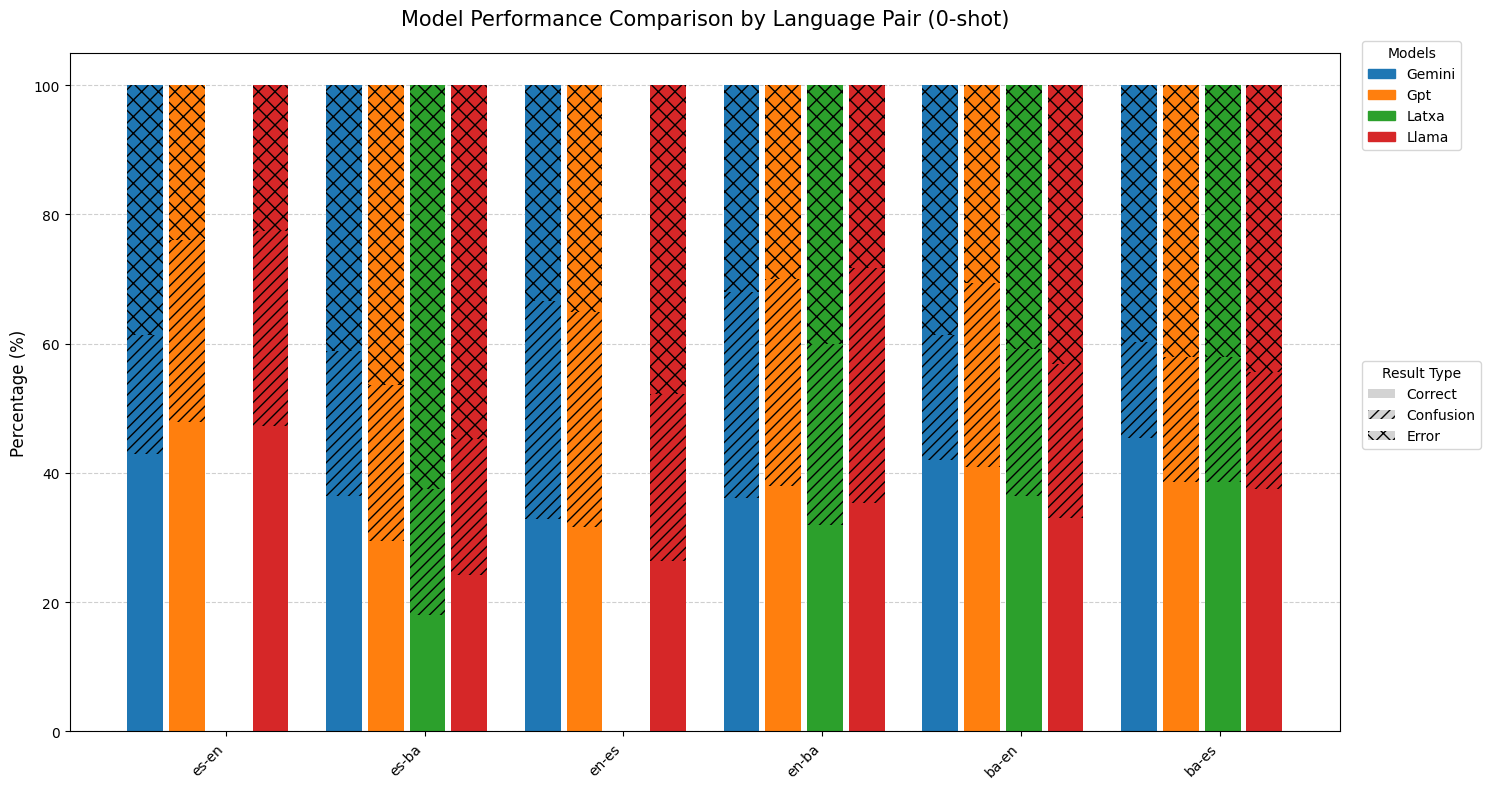

In [28]:
# Define the language pairs to evaluate
language_pairs_to_evaluate = ['es-en', 'es-ba', 'en-es', 'en-ba', 'ba-en', 'ba-es']

# Compile results for the '0-shot' prompt type
results_0shot = compile_results_by_prompt(dataframes, language_pairs_to_evaluate, 'response_0shot')

# Plot the comparative results for the '0-shot' prompt type
plot_model_comparison_by_prompt(results_0shot, '0-shot')


In [29]:
def plot_best_models_for_term(best_models_df, term, language_pair):
    """
    Generates a bar chart using Matplotlib to visualize the accuracy of the best models
    for a specific term across different prompt types.

    Args:
        best_models_df (pd.DataFrame): DataFrame containing the best models' information
                                       (e.g., returned by get_best_models_for_term).
        term (str): The specific term being evaluated (used in the chart title).
        language_pair (str): The language pair used for the evaluation (used in the chart title).
    """
    if best_models_df.empty:
        print(f"No data available to plot for the term '{term}' in the language pair '{language_pair}'.")
        return

    # Create a copy to avoid SettingWithCopyWarning
    plot_data = best_models_df.copy()
    
    # Ensure 'Accuracy (%)' values are numeric
    plot_data['Accuracy (%)'] = pd.to_numeric(plot_data['Accuracy (%)'], errors='coerce').fillna(0.0)

    plt.figure(figsize=(12, 7))  # Adjust figure size for better readability
    
    # Create the bar chart using plt.bar
    bars = plt.bar(
        plot_data['Prompt Type'],
        plot_data['Accuracy (%)'],
        color=plt.cm.viridis(np.linspace(0, 1, len(plot_data)))  # Assign distinct colors to each bar
    )

    # Add value labels on top of the bars
    ax = plt.gca()  # Get the current axes

    for i, bar in enumerate(bars):
        accuracy = plot_data.loc[i, 'Accuracy (%)']
        best_models = plot_data.loc[i, 'Best Model(s)']
        
        # Adjust the text for the annotation
        if best_models == 'N/A':
            text_label = f'{accuracy:.2f}%'
        else:
            model_list = best_models.split(', ')
            if len(model_list) > 1:  # If there is more than one model (tie)
                # Display the first model and the count of additional models
                display_models = f'{model_list[0]} (+{len(model_list)-1})'
            else:
                display_models = model_list[0]
            
            # Heuristic to shorten long model names to avoid overlapping
            if len(display_models) > 15:
                display_models = display_models[:12] + '...'
            
            text_label = f'{accuracy:.2f}%\n({display_models})'  # Accuracy and model name(s)

        # Position the text slightly above the bar
        ax.text(bar.get_x() + bar.get_width() / 2, bar.get_height() + 1.5, text_label,
                ha='center', va='bottom', color='black', fontsize=9)

    # Set axis labels and title
    plt.xlabel('Prompt Type', fontsize=12)
    plt.ylabel('Accuracy (%)', fontsize=12)
    plt.title(f"Accuracy of Best Models for Term: '{term}' in Language Pair: '{language_pair}'", fontsize=14)
    plt.ylim(0, 100)  # Set y-axis scale from 0 to 100
    plt.grid(axis='y', linestyle='--', alpha=0.7)  # Add horizontal grid lines
    plt.tight_layout()  # Adjust layout to prevent label overlap
    plt.show()


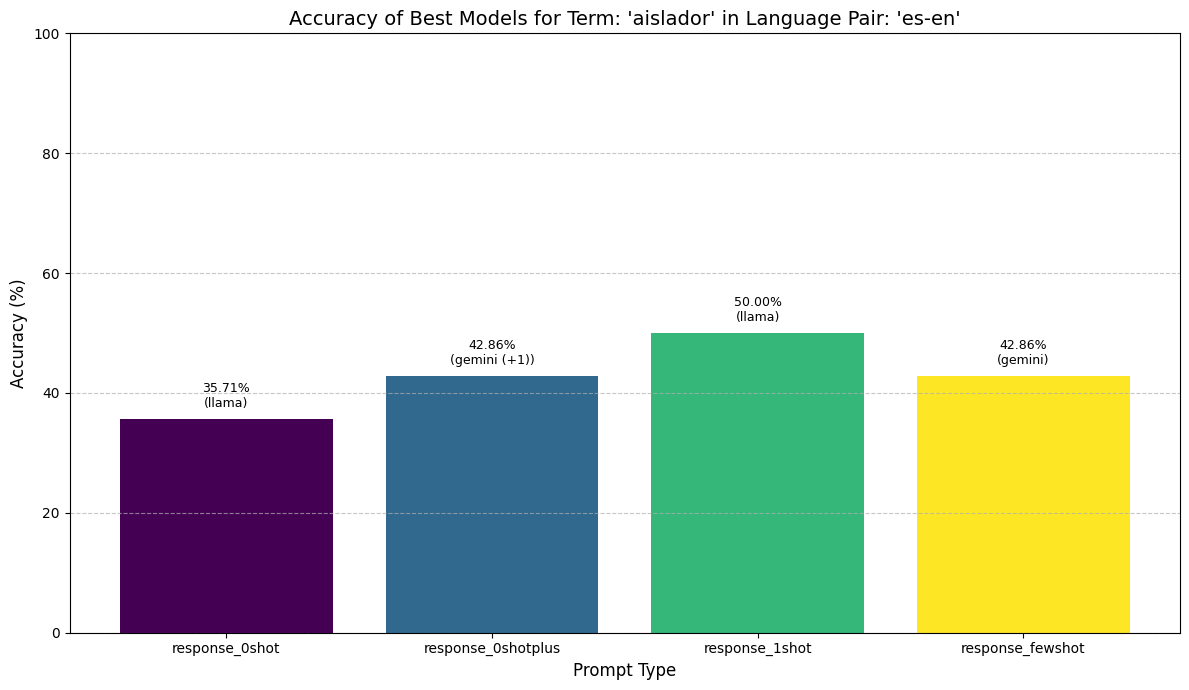

In [30]:
# Retrieve the best models for the term 'aislador' in the 'es-en' language pair
best_models_for_aislador = get_best_models_for_term('aislador', 'es-en', dataframes)

# Plot the accuracy of the best models for the term 'aislador' in the 'es-en' language pair
plot_best_models_for_term(best_models_for_aislador, 'aislador', 'es-en')

In [31]:
def plot_model_accuracy_by_prompt_and_pair(dataframes_dict, target_language_pair, target_prompt_type):
    """
    Generates a bar plot to visualize the accuracy of each model for a specific prompt type and language pair.

    Args:
        dataframes_dict (dict): Dictionary containing the loaded DataFrames, structured as:
                                {model_name: {language_pair: DataFrame}}.
        target_language_pair (str): The language pair to evaluate (e.g., 'en-es', 'ba-en').
        target_prompt_type (str): The type of prompt to evaluate (e.g., 'response_0shot', 'response_fewshot').

    Returns:
        None: Displays the bar plot.
    """
    print(f"\n📊 Plotting Model Accuracy for Prompt Type: '{target_prompt_type}' in Language Pair: '{target_language_pair}'")

    # Retrieve the comparison data for the specified language pair and prompt type
    comparison_df = compare_model_accuracies_by_pair_and_prompt(dataframes_dict, target_language_pair, target_prompt_type)

    if comparison_df.empty:
        print(f"No data available to plot for language pair '{target_language_pair}' "
              f"and prompt type '{target_prompt_type}'.")
        return

    # Extract models and their corresponding accuracies
    models = comparison_df['Model']
    accuracies = comparison_df['Accuracy (%)']

    # Create the bar plot
    plt.figure(figsize=(12, 7))  # Adjust figure size for better readability
    colors = plt.cm.viridis(np.linspace(0, 1, len(models)))  # Generate distinct colors for each bar
    bars = plt.bar(models, accuracies, color=colors)

    # Add accuracy labels on top of the bars
    ax = plt.gca()  # Get the current axes object
    for bar in bars:
        height = bar.get_height()  # Get the height of the bar (accuracy value)
        ax.text(bar.get_x() + bar.get_width() / 2,  # X-position: center of the bar
                height + 1.5,  # Y-position: slightly above the bar
                f'{height:.2f}%',  # Text label (accuracy formatted to 2 decimal places)
                ha='center', va='bottom', fontsize=9, color='black')  # Text alignment and style

    # Customize the plot
    plt.xlabel('Model', fontsize=12)
    plt.ylabel('Accuracy (%)', fontsize=12)
    plt.title(f"Model Accuracy for '{target_prompt_type}' Prompt in '{target_language_pair}'", fontsize=14)
    plt.ylim(0, 100)  # Set y-axis limits from 0 to 100 for accuracy percentage
    plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for better readability
    plt.grid(axis='y', linestyle='--', alpha=0.7)  # Add horizontal grid lines
    plt.tight_layout()  # Adjust layout to prevent label overlap
    plt.show()



📊 Plotting Model Accuracy for Prompt Type: 'response_1shot' in Language Pair: 'en-ba'
🔍 Comparing models for language pair: 'en-ba' and prompt type: 'response_1shot'

  ✅ Evaluated: 'gemini' | Accuracy: 71.76%
  ✅ Evaluated: 'llama' | Accuracy: 74.12%
  ✅ Evaluated: 'gpt' | Accuracy: 67.65%
  ✅ Evaluated: 'latxa' | Accuracy: 51.88%


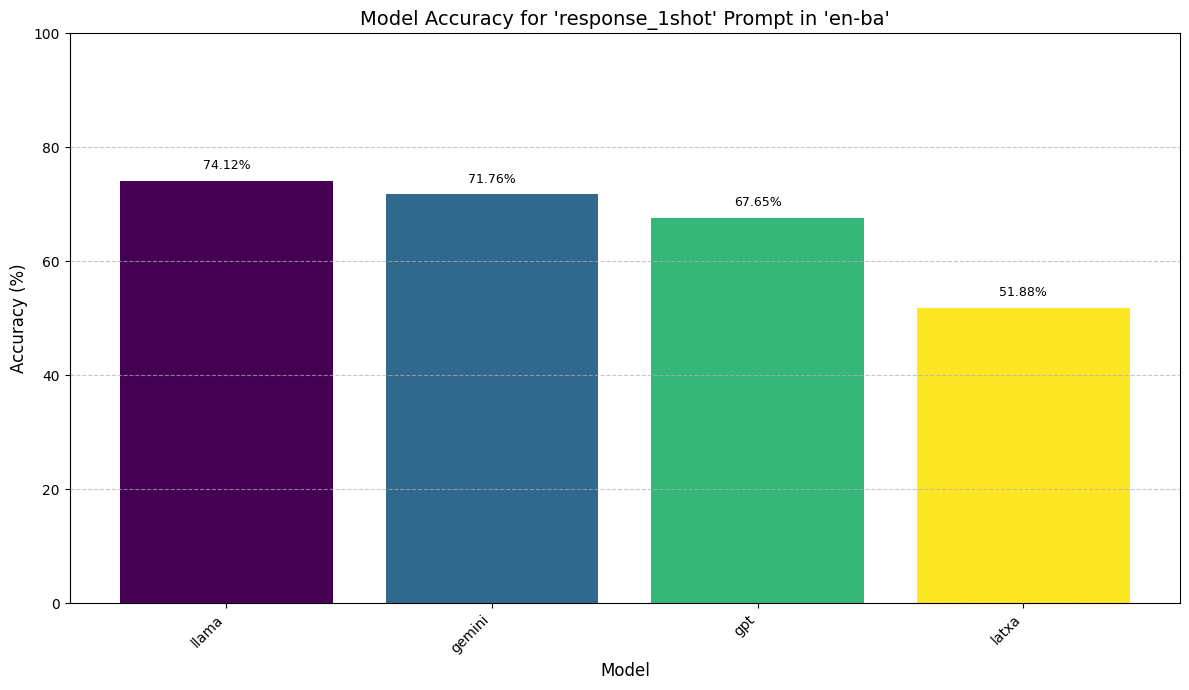

In [32]:
# Plot model accuracy for the 'en-ba' language pair and 'response_1shot' prompt type
language_pair_example = 'en-ba'
prompt_type_example = 'response_1shot'

# Call the function to plot the accuracy of models for the specified language pair and prompt type
plot_model_accuracy_by_prompt_and_pair(dataframes, language_pair_example, prompt_type_example)


In [33]:
def plot_prompt_accuracy(language_pair: str, model_name: str, dataframes_dict: dict, prompt_types: list = None):
    """
    Generates and displays a bar chart showing the accuracy percentages
    of different prompt types for a specified model and language pair,
    using Matplotlib.

    Args:
        language_pair (str): The language pair for evaluation (e.g., 'en-es', 'ba-en').
        model_name (str): The name of the model to evaluate (e.g., 'gpt-4', 'llama-2').
        dataframes_dict (dict): A dictionary containing the evaluation DataFrames.
                                 Expected structure: {model_name: {language_pair: DataFrame}}.
        prompt_types (list, optional): A list of prompt types to evaluate (e.g., ['response_0shot', 'response_fewshot']).

    Returns:
        None: The function displays a plot but does not return any value.
    """

    if prompt_types is None:
        prompt_types = ['response_0shot', 'response_0shotplus', 'response_1shot', 'response_fewshot']
    
    accuracies = get_model_prompt_accuracies(model_name, language_pair, dataframes_dict, prompt_types)

    if not accuracies:
        print(f"No accuracy data found for model '{model_name}' and language pair '{language_pair}'. "
              f"Plot cannot be generated.")
        return

    # Map internal prompt keys to readable labels
    prompt_labels_map = {
        'response_0shot': '0-Shot',
        'response_0shotplus': '0-Shot Plus',
        'response_1shot': '1-Shot',
        'response_fewshot': 'Few-Shot'
    }

    # Prepare data for plotting, ensuring consistent order
    labels = []
    values = []

    for p_type in prompt_types:
        if p_type in accuracies:
            labels.append(prompt_labels_map.get(p_type, p_type))
            values.append(accuracies[p_type])

    if not labels:
        print(f"No valid prompt accuracy data to plot for model '{model_name}' and language pair '{language_pair}'.")
        return

    # Create the plot
    plt.figure(figsize=(10, 6))
    bars = plt.bar(labels, values, color=['skyblue', 'lightcoral', 'lightgreen', 'gold'])

    # Customize the plot
    plt.title(f'Accuracy of Prompt Types for {model_name} ({language_pair})', fontsize=16)
    plt.xlabel('Prompt Type', fontsize=12)
    plt.ylabel('Accuracy (%)', fontsize=12)
    plt.ylim(0, 100)
    plt.grid(axis='y', linestyle='--', alpha=0.7)

    # Add accuracy percentages on top of the bars
    for bar in bars:
        yval = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2, yval + 1, f'{yval:.2f}%', ha='center', va='bottom', fontsize=10)

    plt.tight_layout()
    plt.show()

🔍 Retrieving accuracies for model 'gpt' and language pair 'en-ba'.
  ✅ 'response_0shot' Accuracy: 37.94%
  ✅ 'response_0shotplus' Accuracy: 79.71%
  ✅ 'response_1shot' Accuracy: 67.65%


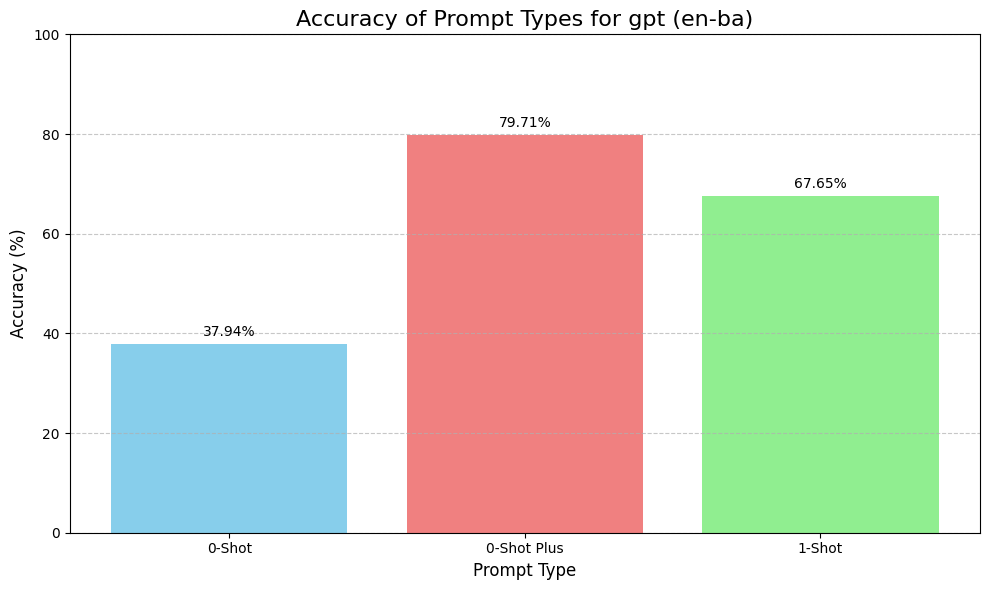

In [34]:
# Test the function `plot_prompt_accuracy` for the model 'gpt' and language pair 'en-ba'

# Define the model and language pair for testing
model_name = 'gpt'
language_pair = 'en-ba'
prompt_types = ['response_0shot', 'response_0shotplus', 'response_1shot']

# Call the function to plot the accuracy of different prompt types for the specified model and language pair
# The function will generate a bar chart showing the accuracy percentages for each prompt type
plot_prompt_accuracy(language_pair, model_name, dataframes, prompt_types)

In [35]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

def plot_prompt_comparison_by_model(language_pair: str, model_data: dict, prompt_types: list):
    """
    Generates and displays a bar chart comparing the accuracy of different prompt types
    across models for a specific language pair using Matplotlib.

    Args:
        language_pair (str): The language pair for evaluation (e.g., 'en-es', 'ba-en').
        model_data (dict): A dictionary where keys are model names and values are dictionaries
                           containing language pair DataFrames.
        prompt_types (list): A list of prompt type keys to include in the comparison
                             (e.g., ['response_0shot', 'response_fewshot']).

    Returns:
        None: Displays a bar chart.
    """
    # Map prompt type keys to user-friendly labels
    prompt_labels = {
        'response_0shot': '0-Shot',
        'response_0shotplus': '0-Shot Plus',
        'response_1shot': '1-Shot',
        'response_fewshot': 'Few-Shot'
    }

    # Collect accuracy data for each model and prompt type
    model_accuracies = {}
    for model_name, language_data in model_data.items():
        if language_pair not in language_data:
            print(f"Warning: Language pair '{language_pair}' not found for model '{model_name}'. Skipping.")
            continue

        df_language_pair = language_data[language_pair]
        if df_language_pair.empty:
            print(f"Warning: DataFrame for model '{model_name}' and language pair '{language_pair}' is empty. Skipping.")
            continue

        # Assuming `get_model_prompt_accuracies` is defined elsewhere
        all_accuracies = get_model_prompt_accuracies(model_name, language_pair, model_data)

        # Filter and map accuracies for the specified prompt types
        filtered_accuracies = {
            prompt_labels.get(prompt, prompt): all_accuracies.get(prompt, float('nan'))
            for prompt in prompt_types
            if not pd.isna(all_accuracies.get(prompt, float('nan')))
        }

        if filtered_accuracies:
            model_accuracies[model_name] = filtered_accuracies

    if not model_accuracies:
        print(f"No data available for language pair '{language_pair}' and specified prompt types. Cannot generate plot.")
        return

    # Prepare data for plotting
    models = list(model_accuracies.keys())
    prompt_labels_ordered = [prompt_labels.get(prompt, prompt) for prompt in prompt_types]
    num_models = len(models)
    num_prompts = len(prompt_labels_ordered)

    if num_prompts == 0:
        print("No prompt types selected for comparison. Cannot generate plot.")
        return

    bar_width = 0.8 / num_prompts  # Adjust bar width for grouped bars
    x_positions = np.arange(num_models)  # Base positions for models on the x-axis

    plt.figure(figsize=(12, 7))

    # Generate distinct colors for each prompt type
    color_map = plt.colormaps.get_cmap('Set2')
    colors = [color_map(i / (num_prompts - 1)) for i in range(num_prompts)]

    # Plot bars for each prompt type
    for i, prompt_label in enumerate(prompt_labels_ordered):
        accuracies = [
            model_accuracies[model].get(prompt_label, 0) for model in models
        ]
        # Adjust x-positions for grouped bars
        bar_positions = x_positions + i * bar_width - (num_prompts - 1) * bar_width / 2
        plt.bar(bar_positions, accuracies, bar_width, label=prompt_label, color=colors[i])

    # Customize the plot
    plt.title(f'Prompt Type Comparison by Model for {language_pair}', fontsize=16)
    plt.xlabel('Model', fontsize=12)
    plt.ylabel('Accuracy (%)', fontsize=12)
    plt.ylim(0, 100)
    plt.xticks(x_positions, models, rotation=45, ha='right', fontsize=10)
    plt.yticks(fontsize=10)
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.legend(title='Prompt Type', bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=10, title_fontsize=11)

    plt.tight_layout()
    plt.show()


🔍 Retrieving accuracies for model 'gemini' and language pair 'ba-es'.
  ✅ 'response_0shot' Accuracy: 45.45%
  ✅ 'response_0shotplus' Accuracy: 82.95%
  ✅ 'response_1shot' Accuracy: 72.73%
  ✅ 'response_fewshot' Accuracy: 72.73%
🔍 Retrieving accuracies for model 'llama' and language pair 'ba-es'.
  ✅ 'response_0shot' Accuracy: 37.50%
  ✅ 'response_0shotplus' Accuracy: 92.05%
  ✅ 'response_1shot' Accuracy: 87.50%
  ✅ 'response_fewshot' Accuracy: 75.00%
🔍 Retrieving accuracies for model 'gpt' and language pair 'ba-es'.
  ✅ 'response_0shot' Accuracy: 38.64%
  ✅ 'response_0shotplus' Accuracy: 89.77%
  ✅ 'response_1shot' Accuracy: 80.68%
  ✅ 'response_fewshot' Accuracy: 73.86%
🔍 Retrieving accuracies for model 'latxa' and language pair 'ba-es'.
  ✅ 'response_0shot' Accuracy: 38.64%
  ✅ 'response_0shotplus' Accuracy: 79.55%
  ✅ 'response_1shot' Accuracy: 78.41%
  ✅ 'response_fewshot' Accuracy: 68.18%


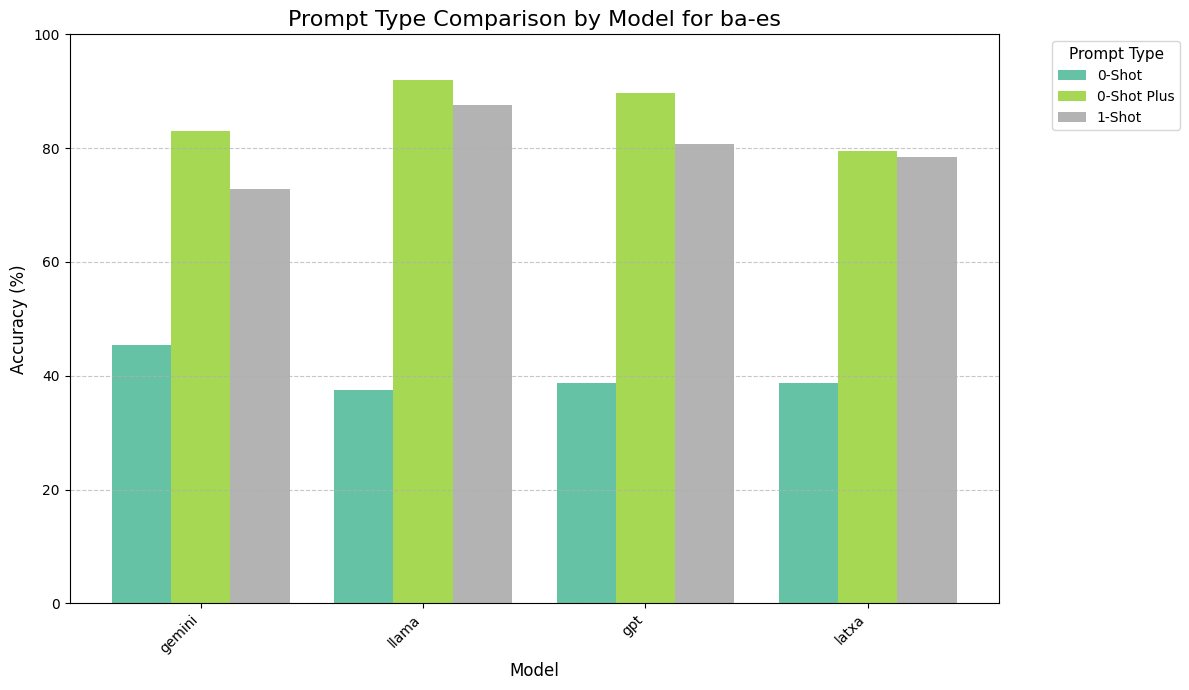

In [36]:
# Test the function `plot_model_comparison_by_prompt_type` for the language pair 'en-ba' and selected prompt types

# Define the language pair and prompt types for testing
language_pair = 'ba-es'  # Example language pair
prompt_types_to_compare = ['response_0shot', 'response_0shotplus', 'response_1shot']

# Call the function to plot the comparison of models for the specified language pair and prompt types
plot_prompt_comparison_by_model(language_pair, dataframes, prompt_types_to_compare)